# Task 0
先读入数据，并导入所需要的包，为模型建立做准备

In [3]:
# 导入需要的包
import json
import torch
import numpy as np
from tqdm import tqdm
from collections import Counter
import re
from torch import nn
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import math
import pickle
from collections import defaultdict

In [4]:
# 读入数据，依旧使用上次的wiki data，因此对数据集信息不再赘述。
np.random.seed(0)
wiki_data = []
with open("./NLP/NLP_PJ2/enwiki_20220201.json","r") as f:
    for each_line in f:
        record = json.loads(each_line)
        wiki_data.append(record)
print(len(wiki_data))

10000


In [5]:
# 设置运行内核
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)

Device:  cuda


In [6]:
# 定义一些超参数
MIN_FREQ = 10 # 参与训练的word的最小出现频次
ALPHA = 0.75 # 调整负采样的概率
WINDOW_SIZE = 5 # skip gram滑动的窗口大小，为左右各一个window
BATCH_SIZE = 128 # 当为1时即为SGD算法
EMBEDDING_SIZE = 100 # 嵌入向量的大小
K = 5 # 负采样和正采样的比例
LEARNING_RATE = 1e-3 # 参数更新的学习率

这部分超参数主要用于word2vec的模型训练过程，之后会解释超参数的选择原因。

# Task 1
使用上面导入的enwiki_20220201.json作为训练数据，并手动实现Skip Gram with Negative Sampling算法。建立词嵌入的模型，并探究超参数对模型的影响。
在训练之前，要首先对数据进行预处理。
## 数据预处理
将数据分词，只保留英文单词，并将所有单词小写。另外，在每个句子连接前在开头和结尾加上开头标识符和结尾标识符，来确保之后的正采样不会跨句子采样，造成训练样本的干扰，同时让开头标识符和结尾标识符也参与训练也可以将开头结尾这一特征加入网络的训练过程，对嵌入结果的准确性可能有所提高。
在完成数据的基本处理后，再对数据集进行一下裁剪，将出现次数较少的样本剔除训练集，主要有两点原因：一是这些单词出现的次数较少，在设定的训练轮数内并不会得到较好的收敛结果；二是这些单词出现频率也决定了我们基本不会在后续进一步的任务中遇到，同时它们在文本中也是不重要的，而减去这一部分正好也可以减轻我们模型训练的压力。
在这里，我暂时将这个最低频次设为10，即**在每一个类别文本都至少出现一次的期望值**。

In [15]:
def data_preprocess(data, min_freq):
    '''
    :param data: text that need to be preprocessed
    :param min_freq: Minimum frequency of participation in training
    :return: a list contained tokens to be trained
    '''
    processed_data = []
    for text_dic in tqdm(data):
        processed_text = re.findall(r'[a-z]+', text_dic['text'].lower()) # 只保留英文单词
        processed_data.append('<s>')  # 区分每个文本的始末
        processed_data.extend(processed_text)
        processed_data.append('</s>')
    count_tokens = Counter(processed_data)
    processed_data = [token for token in processed_data if count_tokens[token] > min_freq]
    return processed_data


In [16]:
processed_data = data_preprocess(wiki_data, MIN_FREQ)

100%|██████████| 10000/10000 [00:18<00:00, 552.65it/s]


In [21]:
# 将文本转化为数值，方便后续训练
vocab = set(processed_data)  # 词典
word2int = {word: ii for ii, word in enumerate(vocab)} # 单词-数值对应表
int2word = {ii: word for ii, word in enumerate(vocab)} # 数值-单词对应表
int_text = [word2int[w] for w in processed_data] # 将文本数据按照上面的单词-数值对应表转化为数值列表
start = word2int['<s>']  # 标记开头
end = word2int['</s>']  # 标记结尾
V = len(vocab)  # 词典大小

In [22]:
# 检查数值化的结果
print(V)
print(start)
print(end)

73800
60029
32546


In [23]:
# 计算负采样的频率，这里要保证之后选取了频率后能对应回word，因此加入频率表的顺序是有讲究的
data_freq = Counter(processed_data)  # 统计裁剪过后的训练集单词出现频次
freq = []
for ii in range(V):
    freq.append(data_freq[int2word[ii]])  # 按照int2word的顺序插入频数值，保证下标为对应的单词的数值索引
freq = torch.tensor(freq) / len(processed_data)
freq = freq ** ALPHA  # 调整word的频率值，降低出现次数多的单词频率，提高出现次数少的单词频率
freq = freq / freq.sum()

In [11]:
# 检查归一化
print(freq.sum())
print(len(freq))
print(freq[:10])

tensor(1.)
73800
tensor([3.2111e-06, 3.3404e-06, 1.3800e-06, 8.1454e-06, 3.0276e-05, 4.1448e-06,
        1.3800e-06, 1.2806e-05, 9.0824e-06, 1.8705e-06])


## 数据采样
对于数据集给定的任意一个中心词，采样它周围window size大小的正样本。但这里做了一个处理为，不跨句采样但会采样开头标识符和结尾标识符。

In [17]:
# 给定中心词和window size，取得positive samples
def get_pos_sample(word_seq, center, window_size, start, end):
    '''
    Get the words in the center's window
    :param word_seq: A sequence of text (list)
    :param center: the target of the positive sample
    :param window_size: the edge of the positive sample
    :param start: the start sign of text
    :param end: the end sign of text
    :return: A list contain all positive samples
    '''
    left = []
    right = []
    left_done = False
    right_done = False
    for i in range(1, window_size + 1):
        if not left_done:
            if center - i >= 0 and word_seq[center - i] != start:
                left.append(word_seq[center - i])
            elif center - i >= 0 and word_seq[center - i] == start:
                # 只保留开头标识符就不再遍历了
                left.append(word_seq[center - i])
                left_done = True
            else:
                left_done = True
        if not right_done:
            if center + i < len(word_seq) and word_seq[center + i] != end:
                right.append(word_seq[center + i])
            elif center + i < len(word_seq) and word_seq[center + i] == end:
                # 同理只保留结尾标识符就不再遍历了
                right.append(word_seq[center + i])
                right_done = True
            else:
                right_done = True
    pos_sample = set(left)
    pos_sample.update(right)
    return list(pos_sample)

In [19]:
# 进行测试
print(get_pos_sample(int_text[:6], 3, 5, start, end))
print(int_text[:6])
print(int2word[int_text[0]]) # 文本第一个应该是start标识符

[67241, 34575, 40344, 63834, 54044]
[40344, 63834, 34575, 23966, 54044, 67241]
<s>


In [14]:
# 为神经网络的训练创建(正样本)数据生成器
def generate_batch(text, batch_size, window_size, start, end):
    num_batch = len(text) // batch_size
    for i in range(0, num_batch):
        s = max(i * batch_size - window_size, 0)  # 每个batch序列送入采样之前还需要扩展左右的window size大小，保证样本完整性
        e = min((i+1) * batch_size + window_size, len(text) - 1)
        mini_batch = text[s:e+1]
        batch_x, batch_y = [], []
        for j in range(window_size, window_size + batch_size):
            target = [mini_batch[j]]
            pos_sample = get_pos_sample(mini_batch, j, window_size, start, end)
            batch_x.extend(target * len(pos_sample))
            batch_y.extend(pos_sample)
        yield batch_x, batch_y  # 数据生成器

In [16]:
# 测试数据生成器
batch = generate_batch(int_text[:20],6,3,start,end)
for x, y in batch:
    print('X:',x)
    print(len(x))
    print('Y:',y)

X: [23966, 23966, 23966, 23966, 23966, 54044, 54044, 54044, 54044, 54044, 54044, 67241, 67241, 67241, 67241, 67241, 67241, 39297, 39297, 39297, 39297, 39297, 39297, 67971, 67971, 67971, 67971, 67971, 68129, 68129, 68129, 68129]
32
Y: [39297, 67241, 34575, 63834, 54044, 39297, 67971, 67241, 34575, 63834, 23966, 39297, 68129, 67971, 34575, 54044, 23966, 68129, 67971, 67241, 62795, 54044, 23966, 39297, 68129, 67241, 62795, 54044, 67241, 39297, 62795, 67971]
X: [39297, 39297, 39297, 39297, 39297, 39297, 67971, 67971, 67971, 67971, 67971, 67971, 68129, 68129, 68129, 68129, 68129, 62795, 62795, 62795, 62795, 62795, 62795, 39443, 39443, 39443, 39443, 39443, 62795, 62795, 62795, 62795, 62795, 62795]
34
Y: [68129, 67971, 67241, 62795, 54044, 23966, 39297, 68129, 67241, 62795, 39443, 54044, 39297, 67971, 67241, 62795, 39443, 68129, 39297, 67971, 7942, 62795, 39443, 68129, 67971, 58437, 7942, 62795, 68129, 58437, 7942, 71173, 62795, 39443]
X: [7942, 7942, 7942, 7942, 7942, 58437, 58437, 58437, 58

## 搭建模型
SG模型可以类比一个两层的神经网络，隐藏层的权重是输入（即target Word）的嵌入矩阵，输出层的权重是输出（即正采样和负采样）的嵌入矩阵。嵌入的过程和全连接层的原理一致。但是由于全连接层需要输入的形式是one-hot向量，维度即为词典大小。由于我们的数据集词典较大，这个方法对内存是很大的考验。因此，这里选用作用相同的embedding层替代，输入为单词的索引，大大降低内存消耗。
模型损失函数为logistic的交叉熵损失函数。

In [21]:
# 准备工作完毕，开始构建SKNS模型
class SGNS(nn.Module):
    def __init__(self, V, num_embed, neg_freq, device, k):
        super().__init__()
        self.V = V
        self.num_embed = num_embed
        self.neg_freq = neg_freq
        self.device = device
        self.k = k
        # 构建输入矩阵和输出矩阵，反映到神网上即隐藏层和输出层
        self.input = nn.Embedding(V, num_embed)
        self.output = nn.Embedding(V, num_embed)
        # 采取Dan Jurafsky书中提及的优化初始值
        self.input.weight.data.uniform_(-0.5, 0.5)
        self.output.weight.data.uniform_(-0.5, 0.5)

    def target_input(self, target_words):
        '''
        input target word
        :param target_words: a list of input target words
        :return: the embedding vector of the target word
        '''
        input_embed = self.input(target_words)
        return input_embed

    def pos_output(self, pos_samples):
        '''
        output the positive samples
        :param pos_samples: a list of output positive words
        :return: the embedding vector of the positive samples
        '''
        output_embed = self.output(pos_samples)
        return output_embed

    # 因为负样本的采样对于所有target words的流程是一样的，因此单独写一个负样本的嵌入函数，包含采样和嵌入两个过程
    def neg_output(self, num_pos):
        '''
        output the negative samples, which have num_pos * K samples
        :param num_pos: the number of positive samples
        :return: the embedding vector of the negative samples
        '''
        # 和正样本呈k比例采样负样本
        neg_samples = torch.multinomial(input = self.neg_freq, num_samples=self.k * num_pos, replacement=True)
        neg_samples = neg_samples.to(self.device)
        neg_output = self.output(neg_samples)
        return neg_output


In [30]:
# 定义我们要使用的logistic loss（交叉熵形式）
class LogLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, target_input, pos_output, neg_output):
        """
        calculate the logistic loss in one train iteration
        :param target_input: the embedding vector of target words [batch_size, 1, num_embed]
        :param pos_output: the embedding vector of positive words [batch_size, num_embed, 1]
        :param neg_output: the embedding vector of negative words [batch_size, num_embed, k]
        :return: the logistic loss
        """
        pos_loss = torch.matmul(target_input, pos_output).squeeze().sigmoid().log()
        neg_loss = torch.matmul(target_input, neg_output).squeeze().neg().sigmoid().log().sum(1)
        # 因为采样的特点，其实每个训练轮次的数据批数会有小波动，为了防止数量对损失带来的影响，这里使用平均值衡量
        return (pos_loss + neg_loss).mean().neg()


## 模型训练
使用Adam梯度下降算法进行优化，会比课堂上使用的SGD下降方法更加稳定。

In [35]:
# 定义模型
model = SGNS(V, EMBEDDING_SIZE, freq, device, K)
criterion = LogLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [71]:
# 定义训练函数
def train(model, criterion, optimizer, int_text, k, batch_size, device, window_size, start, end, n_epoch = 3):
    """
    train model and detect loss on train data
    :param model: Skip Gram with negative sampling
    :param criterion: loss function
    :param optimizer: gradient update optimizer
    :param int_text: train data
    :param k: ratio of negative samples to positive samples
    :param batch_size: batch size
    :param device: 'CPU' or 'GPU'
    :param window_size: the window size of SG
    :param start: start sign of sentence
    :param end: end sign of sentence
    :param n_epoch: Total training rounds
    """
    model.to(device)
    iter = 0
    loss_list = []
    for epoch in range(n_epoch):
        for target, pos in generate_batch(int_text, batch_size, window_size, start, end):
            target = torch.LongTensor(target).to(device)
            pos = torch.LongTensor(pos).to(device)
            # 获得嵌入值
            target_embed = model.target_input(target)
            pos_embed = model.pos_output(pos)
            num_pos, num_embed = pos_embed.shape
            neg_embed = model.neg_output(num_pos)
            # 计算损失
            target_embed = target_embed.view(num_pos, 1, num_embed)
            pos_embed = pos_embed.view(num_pos, num_embed, 1)
            neg_embed = neg_embed.view(num_pos, num_embed, k)
            loss = criterion(target_embed, pos_embed, neg_embed)
            # 更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iter += 1
            # 检测损失值
            if iter % 10 == 0:
                loss_list.append(loss.item())
        print('Epoch:', epoch + 1,'. Train loss:', loss.item())
        plt.figure(figsize = (7,5))
        plt.plot(loss_list)
        plt.show()


Epoch: 1 . Train loss: 0.001057493151165545


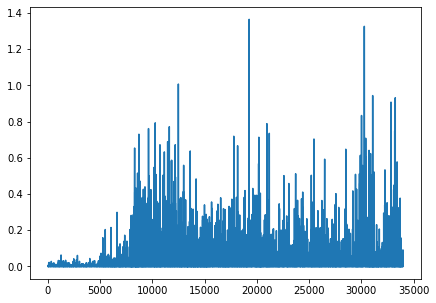

Train time: 2629.69152s


In [72]:
# 开始训练，先尝试训练一轮，验证模型正确性
start_time = time.time()
train(model, criterion, optimizer, int_text, K, 128, device, WINDOW_SIZE, start, end, 1)
end_time = time.time()
print('Train time: %6.5fs' %(end_time-start_time))

Epoch: 1 . Train loss: 3.6151459426037036e-06


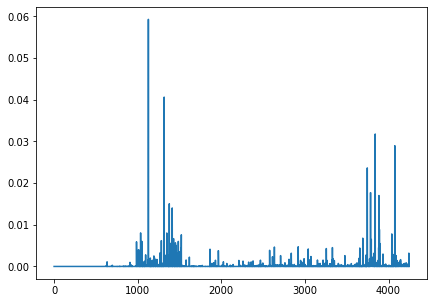

Epoch: 2 . Train loss: 2.3135193316647928e-07


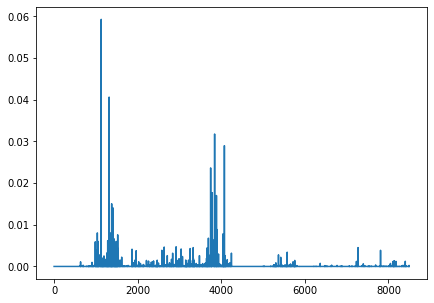

Train time: 1781.62879s


In [133]:
# 尝试训练3轮, 即在原先基础上再训练两轮
start_time = time.time()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
train(model, criterion, optimizer, int_text, K, 1024, device, WINDOW_SIZE, start, end, 2)
end_time = time.time()
print('Train time: %6.5fs' %(end_time-start_time))

可以看到训练后期的损失函数已经降到了非常低的水平，说明模型在训练集上基本稳定了。

## 超参数解释
+ Dimensionality of embeddings：在这次模型训练中，我选择了100作为embedding的嵌入长度。一般来说，100-300都是常选择的嵌入长度，越长的嵌入长度代表对向量越准确的量化。但是随之而来的是更大的参数量需要更加多的训练轮数和更多的训练样本，因此收敛更加不易。我尝试过100,200,300，但是最终模型的训练效果带来的增益差别不大，因此这里选择了比较稳健的100.
+ Window size：根据Dan Jurafsky书中所提，小数据集一般选择3-5作为window size，大的数据集一般选择5-20作为window size。在这里，为了保证嵌入向量估计的尽可能准确和兼顾模型训练时间，我选择了5作为window size。理论上来说，大的window size更有可能将具有某一相同属性的word判定为相似，而小的window size更有可能将同一类的word判为一类，具体见*Speech and Language Processing*。
+ The parameter of negative sampling strategy：在这里，我选择了课堂上推荐的0.75.由于该算法的结果并不直接对应某个问题的解释，因此我没有办法直接评估这个值的好坏，以及尝试出最佳超参数，但是我足够相信课堂推荐的这个先验值。
+ Initial learning rate：对于该超参数，我们可以做个简单的小实验，调节learning rate大小，在部分数据集上训练，下面展示了其中一次learning rate为1的训练：

Epoch: 1 . Train loss: 4.65602445602417


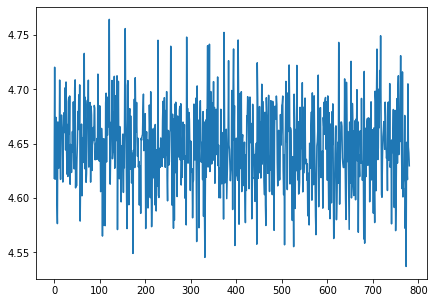

Train time: 59.85779s


In [98]:
model2 = SGNS(V, EMBEDDING_SIZE, freq, device, K)
start_time = time.time()
optimizer = torch.optim.Adam(model.parameters(), lr = 1)
train(model2, criterion, optimizer, int_text[:1000000], K, 128, device, WINDOW_SIZE, start, end, 1)
end_time = time.time()
print('Train time: %6.5fs' %(end_time-start_time))

可以看到由于learning rate太大，模型的损失几乎不收敛。除此之外，我还做了learning rate为其他值的多次尝试。当learning rate过大，就会出现和上面不收敛的情况，当learning rate太小，模型收敛相当慢。最后，经过实验，leaning rate为1e-3~1e-2都是比较合理的。

In [138]:
# 保存模型
path = './NLP/NLP_PJ2/model.pth'
torch.save(model.state_dict(),path)

In [74]:
# 加载模型
l = SGNS(V, EMBEDDING_SIZE, freq, device, K)
l.load_state_dict(torch.load(path))
l.eval()

<All keys matched successfully>

## 模型检查
完成上述模型的训练后，我们对模型的正确性再做一次检验。随便选取两对词，其中cat和dog是我们认为的比较相近的词，而sink和integer则毫不相关，检查一下他们的余弦值，发现结果和我们的认知基本符合。

In [154]:
embed = l.state_dict()['input.weight']
cat = embed[word2int['cat']]
dog = embed[word2int['dog']]
integer = embed[word2int['integer']]
sink = embed[word2int['sink']]
print('The similarity of cat and dog is',torch.dot(cat,dog)/(torch.norm(cat)*torch.norm(dog)))
print('The similarity of integer and sink is',torch.dot(integer, sink)/(torch.norm(integer)*torch.norm(sink)))

The similarity of cat and dog is tensor(0.8619, device='cuda:0')
The similarity of integer and sink is tensor(0.4867, device='cuda:0')


## 使用Gensim训练模型
由于以上模型是我自己手动完成的，各种超参数和优化算法也是基于我的个人理解设置的。但我在完成之后又去了解了gensim包的一些资料和实现代码，发现我自己实现的模型和gensim还是有部分不一样，比如说gensim在模型训练过程中*可以实现学习率的线性下降*，*可以实现高频词的随机下采样*，*以及使用哈希函数随机初始化权重*，还包括gensim使用*并行化*可以在很短时间内训练更多的轮次等等。我担心这些差别会导致我的模型结果结果会与使用标准库的结果有所出入，从而影响后续实验，因此再使用标准库Gensim来训练一次模型，作为后续实验使用的基准。
除了上面提到的gensim实现的其余优化之外，使用gensim的所有超参数我也与自己的模型保持一致。

In [10]:
# 导入相应的包
import gensim

In [159]:
# 由于gensim需要使用的数据格式和上面我建立的自己的模型所需的格式不一样，因此再做一次数据处理。
def prepare_sentence(data):
    '''
    :param data: text that need to be preprocessed
    :return: a list contained tokenized sentences to be trained
    '''
    processed_data = []
    for text_dic in tqdm(data):
        processed_text = re.findall(r'[a-z]+', text_dic['text'].lower()) # 只保留英文单词
        processed_data.append(processed_text)
    return processed_data

In [160]:
sentences = prepare_sentence(wiki_data)

100%|██████████| 10000/10000 [00:19<00:00, 520.05it/s]


In [8]:
# 保存文档的分词结果，后面需要使用
# f = open('./NLP/NLP_PJ2/sentences.pkl','wb')
# pickle.dump(sentences, f)
# f.close()
f1 = open('./NLP/NLP_PJ2/sentences.pkl','rb')
sentences = pickle.load(f1)

In [418]:
# 使用模型训练
gensim_model = gensim.models.Word2Vec(sentences = sentences, vector_size=EMBEDDING_SIZE, window = WINDOW_SIZE, min_count=MIN_FREQ, sg = 1, hs = 0, negative = K, ns_exponent = 0.75)
# 以下是CBOW模型，我也尝试过，但在后续的实验中表现不佳
# gensim_model = gensim.models.Word2Vec(sentences)

In [167]:
# 使用上面同样的实例检查模型的效果
print('The similarity of cat and dog is:')
print(gensim_model.wv.similarity('cat','dog'))
print('The similarity of integer and sink is:')
print(gensim_model.wv.similarity('integer','sink'))

The similarity of cat and dog is:
0.70732117
The similarity of integer and sink is:
0.41889098


In [11]:
# 保存模型
# gensim_model.save('./NLP/NLP_PJ2/gensim_model')
gensim_model = gensim.models.Word2Vec.load('./NLP/NLP_PJ2/gensim_model')

# Task 2
从词汇表中随机生成100、1000和10000个词对。对于每组，打印5个最接近的词对和5个最远的词对。

In [176]:
# from collections import defaultdict
def task2(num_pair, model, V, int2word, word_freq):
    p1 = torch.multinomial(torch.ones(V), num_pair, replacement = True)
    p2 = torch.multinomial(torch.ones(V), num_pair, replacement = True)
    prob = defaultdict(int)
    for i in range(num_pair):
        prob[i] = model.wv.similarity(int2word[p1[i].item()], int2word[p2[i].item()])
    prob = sorted(prob.items(), key = lambda x:x[1])
    print('The 5 least similarity pairs:')
    for i in range(5):
        print(int2word[p1[prob[i][0]].item()],int2word[p2[prob[i][0]].item()],':',prob[i][1].item(),'|',word_freq[int2word[p1[i].item()]],word_freq[int2word[p2[i].item()]])
    print('The 5 most similarity pairs:')
    for i in range(1,6):
        print(int2word[p1[prob[-i][0]].item()],int2word[p2[prob[-i][0]].item()],':',prob[-i][1].item(),'|',word_freq[int2word[p1[-i].item()]],word_freq[int2word[p2[-i].item()]])

In [178]:
# 随机生成100个词对
task2(100, gensim_model, V, int2word, data_freq)

The 5 least similarity pairs:
eugenie mts : 0.002814332488924265 | 6602 27
applause prehistoric : 0.020170141011476517 | 177 3069
procedural surabaya : 0.033858522772789 | 20 24
rebel atmospheric : 0.045809779316186905 | 17 16
nebula tsarist : 0.05480993539094925 | 453 41
The 5 most similarity pairs:
klown dashboard : 0.6016780734062195 | 56 22
protosevich ronson : 0.5907535552978516 | 11 541
polymath demolay : 0.5333346724510193 | 12 21
lewinsky tehelka : 0.5113797187805176 | 12 90
luan proclaims : 0.50966477394104 | 472 23


In [179]:
# 随机生成1000个词对
task2(1000, gensim_model, V, int2word,data_freq)

The 5 least similarity pairs:
nardiers positive : -0.04938410595059395 | 40 30
sensor ben : -0.044608984142541885 | 17 16
unfairly artemis : -0.02243470586836338 | 32 28
poltava pogue : -0.012435365468263626 | 122 110
assuring victorian : -0.012226199731230736 | 89 32
The 5 most similarity pairs:
openssh multiprocessor : 0.8628212213516235 | 17 24
rowboat retracing : 0.76429283618927 | 12 18
vimukthi ano : 0.7468786835670471 | 121 25
salom peralta : 0.7256767153739929 | 55 11
mccrum maitland : 0.6872832775115967 | 22 177


In [180]:
# 随机生成10000个词对
task2(10000, gensim_model, V, int2word, data_freq)

The 5 least similarity pairs:
ional asgard : -0.15650899708271027 | 20 786
imprint hamza : -0.09660996496677399 | 108 792
zeal mm : -0.09306515753269196 | 63 26
rayner gc : -0.08643733710050583 | 54 55
inger fragmentation : -0.0856633186340332 | 191 674
The 5 most similarity pairs:
hemolytic dyskinesia : 0.898503839969635 | 21 40
leukocytes anaerobic : 0.8651134967803955 | 19 44
amini jez : 0.8359630703926086 | 27 199
crawlspace cradling : 0.8306261301040649 | 188 30
chrissie ciaran : 0.8269544243812561 | 239 14


## 发现
上面每行的输出结果，前面两个单词是我们检测到的词对，后面是相似度。间隔符后面是这两个单词在训练集中分别出现的次数。
从结果上来看，可以发现，当词对数越来越多时，**更能发现那些更加相似和更加不相似的词对**。
不相似词对的寻找和我们的基本认知一致，基本上挑选出来的也是出现次数较为合理，保证了训练收敛结果的词对。这里没有对小于0的相似度进行截断为0是因为可能出现过多为0的相似度导致我们不能区分哪些是5个最不相似的词对。
相似词对仔细观察会发现，**有很大一部分是来自专有名词（人名）**，也就是说算法认为这些人名是很相似的，这也是可以理解的，因为人名在语句中扮演的角色都是一致的。除此之外，我发现当词对数量比较少时，相似词对的筛选可能会出现一些在训练集中本身出现次数就很少的词，这让我很怀疑它们嵌入向量的收敛性，这有可能是初始化的方法导致了它们的相似性比较适中，在生成词对比较少时，这些相似性不大不小的词对就脱颖而出了。总的来说，还是10000词对组的结果更加可靠。
在所有输出词对中，最相似的是hemolytic和dyskinesia，即溶血性和运动障碍，都是医学上的术语，第二相似的是leukocytes和anaerobic，即厌氧性和白细胞，也是生物用语，相似性刻画上比较有说服力。

In [182]:
# 对于给定单词，找最相近的五个单词，可以看到效果相当显著
gensim_model.wv.most_similar('cat',topn=5)

[('dog', 0.7073211073875427),
 ('eared', 0.6972287893295288),
 ('tabby', 0.6862895488739014),
 ('kitten', 0.682464599609375),
 ('pet', 0.6803949475288391)]

# Task 3
将文档呈现为嵌入，并使用k-means聚类算法对这些文档嵌入进行聚类，使用Micro/Macro F1分数来衡量这些选择的性能。
## 使用所有单词的嵌入向量平均来聚类

In [25]:
# 先处理文档数据
doc_label = []
start_time = time.time()
doc2vec_mean = []
for i in range(len(wiki_data)):
    doc_vec = 0
    count = 0
    doc_label.append(wiki_data[i]['label'])
    for w in sentences[i]:
        if w in gensim_model.wv:
            doc_vec += gensim_model.wv[w]
            count += 1
    doc_vec = doc_vec / count # 求平均
    doc2vec_mean.append(doc_vec)
end_time = time.time()
print('Processing time: %6.5fs' %(end_time-start_time))

Processing time: 173.09469s


In [478]:
# 使用Kmeans算法进行聚类
start_time = time.time()
result_mean = KMeans(n_clusters=10, random_state=0).fit_predict(doc2vec_mean)
end_time = time.time()
print('Train time: %6.5fs' %(end_time-start_time))

Train time: 3.26361s


首先，要将聚类后的标签和原始标签对应上。这里我选择的方法是选择聚类中占比最大的label作为该簇的label，也即为**投票法**。

In [479]:
for i in range(10):
    label_trans = defaultdict(int)
    for j in range(len(result_mean)):
        if result_mean[j] == i:
            label_trans[doc_label[j]] += 1
    temp_l = max(label_trans, key=lambda x:label_trans[x])
    result_mean = [temp_l if k == i else k for k in result_mean]

In [480]:
# 检查聚类结果的F1-score
print('Use the average of embeddings of all words in each document:')
print('Macro F1-score:')
print(f1_score(result_mean, doc_label, average = 'macro'))
print('Micro F1-score:')
print(f1_score(result_mean, doc_label, average = 'micro'))

Use the average of embeddings of all words in each document:
Macro F1-score:
0.5892674183906916
Micro F1-score:
0.8419000000000001


## 使用文本的第一段单词平均作为嵌入
这里题目要求使用文本的第一段单词作为嵌入样本。但我考虑到由于每个文本的第一段长度不同，这可能会对文档的嵌入造成影响，故这里改为统一的前N个单词，思想都是一样的，使用少部分代表性文本作为文档的嵌入样本。但是具体N的大小确定还需要再做实验探究。

In [486]:
# 由于后面需要实验超参数，故打包为函数使用
def part_mean(length, doc_label):
    global sentences
    print('Use the first',length, 'words in document:')
    start_time = time.time()
    doc2vec_part_mean = []
    for i in range(len(wiki_data)):
        doc_vec = 0
        count = 0
        for w in sentences[i][:length]:
            if w in gensim_model.wv:
                doc_vec += gensim_model.wv[w]
                count += 1
        doc_vec = doc_vec / count # 求平均
        doc2vec_part_mean.append(doc_vec)
    end_time = time.time()
    print('Processing time: %6.5fs' %(end_time-start_time))
    result_mean = KMeans(n_clusters=10).fit_predict(doc2vec_part_mean)
    for i in range(10):
        label_trans = defaultdict(int)
        for j in range(len(result_mean)):
            if result_mean[j] == i:
                label_trans[doc_label[j]] += 1
        temp_l = max(label_trans, key=lambda x:label_trans[x])
        result_mean = [temp_l if k == i else k for k in result_mean]
    print('Macro F1-score:')
    print(f1_score(result_mean, doc_label, average = 'macro'))
    print('Micro F1-score:')
    print(f1_score(result_mean, doc_label, average = 'micro'))
    return doc2vec_part_mean, result_mean

In [482]:
# 实验使用不同长度的文本进行聚类
_, _ = part_mean(50, doc_label)
_, _ = part_mean(80, doc_label)
_, _ = part_mean(200, doc_label)
doc2vec_part_mean, result_part_mean = part_mean(100, doc_label)

Use the first 50 words in document:
Processing time: 2.19723s
Macro F1-score:
0.48402365720020973
Micro F1-score:
0.8369
Use the first 80 words in document:
Processing time: 3.40020s
Macro F1-score:
0.4795445982308057
Micro F1-score:
0.8311
Use the first 200 words in document:
Processing time: 8.00007s
Macro F1-score:
0.5732593821945701
Micro F1-score:
0.8109
Use the first 100 words in document:
Processing time: 4.08379s
Macro F1-score:
0.5799250106653426
Micro F1-score:
0.8321


可以看到，缩减每个文本应用于聚类的单词数后，不仅训练速度大大提高（主要是数据处理速度，提高近100倍），且训练的结果比起使用全篇单词并不太差。其中，使用前100个单词的效果是最好的，我也将以这个标准作为该嵌入方法的最优标准。

## Doc2vec
使用Doc2vec方法对文本进行聚类，然后使用kmeans聚类。

In [60]:
start = time.time()
tagged_data = [TaggedDocument(words=sentences[i], tags=[i]) for i in range(10000)]
doc2vec_doc = Doc2Vec(tagged_data, vector_size=100)
end_time = time.time()
print('Processing time: %6.5fs' %(end_time-start_time))
result_doc = KMeans(n_clusters=10).fit_predict(doc2vec_doc.dv.vectors)
for i in range(10):
    label_trans = defaultdict(int)
    for j in range(len(result_doc)):
        if result_doc[j] == i:
            label_trans[doc_label[j]] += 1
    temp_l = max(label_trans, key=lambda x:label_trans[x])
    result_doc = [temp_l if k == i else k for k in result_doc]
print('Macro F1-score:')
print(f1_score(result_doc, doc_label, average = 'macro'))
print('Micro F1-score:')
print(f1_score(result_doc, doc_label, average = 'micro'))

Macro F1-score:
0.16594674591877223
Micro F1-score:
0.5311


可以看到效果并不是很好，可能是文本比较粗糙，同时数据量也较小，无法训练到较好效果。

## Other new method
### 删除停用词，使用weight mean

In [1]:
def weight_mean(length, doc_label, data_freq):
    print('Use the weight mean of the first',length, 'words in document:')
    stopword = stopwords.words('english')
    global sentences
    global EMBEDDING_SIZE
    start_time = time.time()
    doc2vec_part_mean = []
    for i in range(len(wiki_data)):
        doc_vec = np.zeros(EMBEDDING_SIZE)
        count = 0
        for w in sentences[i][:length]:
            if w in gensim_model.wv and w not in stopword and w in data_freq:
                doc_vec += math.log(1/data_freq[w])*gensim_model.wv[w]
                # doc_vec = [max(doc_vec[i], gensim_model.wv[w][i]) for i in range(EMBEDDING_SIZE)]
                count += 1
        doc_vec = doc_vec / count # 求平均
        doc2vec_part_mean.append(doc_vec)
    end_time = time.time()
    print('Processing time: %6.5fs' %(end_time-start_time))
    result_mean = KMeans(n_clusters=10).fit_predict(doc2vec_part_mean)
    for i in range(10):
        label_trans = defaultdict(int)
        for j in range(len(result_mean)):
            if result_mean[j] == i:
                label_trans[doc_label[j]] += 1
        temp_l = max(label_trans, key=lambda x:label_trans[x])
        result_mean = [temp_l if k == i else k for k in result_mean]
    print('Macro F1-score:')
    print(f1_score(result_mean, doc_label, average = 'macro'))
    print('Micro F1-score:')
    print(f1_score(result_mean, doc_label, average = 'micro'))
    return doc2vec_part_mean, result_mean

先不做weight mean，单独使用删去停用词的文本中所有单词的嵌入向量的平均值进行嵌入。

In [488]:
# 先看看删除停用词的效果
doc2vec_stop_mean, result_stop = weight_mean(-1, doc_label, data_freq)

Use the weight mean of the first -1 words in document:
Processing time: 201.63320s
Macro F1-score:
0.511531814359557
Micro F1-score:
0.7946999999999999


可以看到删除了大量的停用词之后预测的结果并没有太多的下降，说明停用词对文本的分类起的效果是比较小的，因此保留这个改变，继续考虑对单词进行加权求和。

In [526]:
doc2vec_weight_mean, result_weight = weight_mean(190, doc_label, data_freq)

Use the weight mean of the first 190 words in document:
Processing time: 11.58904s
Macro F1-score:
0.4867379228997065
Micro F1-score:
0.8472


以上是调整权重系数和参与加权和单词数后最好的结果了，但是可以发现效果并没有提升，只是在保证准确性的基础上大大降低了运行速度。
紧接着，尝试一下取嵌入向量最大值的文档嵌入方法。
### 最大值嵌入

In [24]:
_,_ = weight_mean(190, doc_label, data_freq)

Use the weight mean of the first 190 words in document:
Processing time: 261.70472s
Macro F1-score:
0.4596363795014614
Micro F1-score:
0.7968


效果并不好，且处理时间非常长（主要是由于取最大值这一步比较耗时）。
接下来，尝试其他聚类方法。
### PCA降维
考虑到我们用来聚类的向量维度是100维的，这是非常大的，且这100维的特征中可能含有噪声，因此考虑对数据先进行降维再聚类。

In [32]:
# 使用PCA先降维再使用kmeans聚类
pca = PCA(n_components=50)
pca_data = pca.fit_transform(doc2vec_mean)
result_pca = KMeans(n_clusters=10).fit_predict(pca_data)
for i in range(10):
    label_trans = defaultdict(int)
    for j in range(len(result_pca)):
        if result_pca[j] == i:
            label_trans[doc_label[j]] += 1
    temp_l = max(label_trans, key=lambda x:label_trans[x])
    result_pca = [temp_l if k == i else k for k in result_pca]
print('Macro F1-score:')
print(f1_score(result_pca, doc_label, average = 'macro'))
print('Micro F1-score:')
print(f1_score(result_pca, doc_label, average = 'micro'))

Macro F1-score:
0.58996898948441
Micro F1-score:
0.843


可以看到是比目前效果最好的的第一种嵌入方法的评价系数要高一点的，因此之前的思路是正确的。但是在多次调节降维后的大小之后发现即使是效果最好的超参数50的提升也并不无显著，因此这个方法的上限可能就在这里了。尝试其他聚类方法。
### 谱聚类

In [45]:
# 使用谱聚类
result_spec = SpectralClustering(n_clusters=10).fit_predict(np.array(doc2vec_mean))
for i in range(10):
    label_trans = defaultdict(int)
    for j in range(len(result_spec)):
        if result_spec[j] == i:
            label_trans[doc_label[j]] += 1
    temp_l = max(label_trans, key=lambda x:label_trans[x])
    result_spec = [temp_l if k == i else k for k in result_spec]
print('Macro F1-score:')
print(f1_score(result_spec, doc_label, average = 'macro'))
print('Micro F1-score:')
print(f1_score(result_spec, doc_label, average = 'micro'))

Macro F1-score:
0.5127761638322743
Micro F1-score:
0.7779


效果一般
### 层次聚类

In [52]:
# 使用层次聚类
result_bisection = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(np.array(doc2vec_mean))
for i in range(10):
    label_trans = defaultdict(int)
    for j in range(len(result_bisection)):
        if result_bisection[j] == i:
            label_trans[doc_label[j]] += 1
    temp_l = max(label_trans, key=lambda x:label_trans[x])
    result_bisection = [temp_l if k == i else k for k in result_bisection]
print('Macro F1-score:')
print(f1_score(result_bisection, doc_label, average = 'macro'))
print('Micro F1-score:')
print(f1_score(result_bisection, doc_label, average = 'micro'))

Macro F1-score:
0.591455507452672
Micro F1-score:
0.8426


尝试了多种连接方法，效果最好的还是ward连接方法。比起使用kmeans聚类效果稳定地变好了一点，也是所有方法里面效果最好的一个聚类方法，主要体现在Macro F1上（即准确率），但是差别不大。
### TSNE降维
受到之前的PCA降维效果的启发，这里尝试使用T-SNE降维后再聚类。
（后经咨询老师，了解到T-SNE主要用于作图，这种方法走歪路了。但这里依旧保留结果作为参考）

In [58]:
# 使用TSNE先对数据降维，然后使用KMeans聚类
tsne = TSNE(n_components=2, init = 'pca', learning_rate=200, n_iter=1000)
tsne_data = tsne.fit_transform(doc2vec_mean)
result_tsne = AgglomerativeClustering(n_clusters=10).fit_predict(tsne_data)
for i in range(10):
    label_trans = defaultdict(int)
    for j in range(len(result_tsne)):
        if result_tsne[j] == i:
            label_trans[doc_label[j]] += 1
    temp_l = max(label_trans, key=lambda x:label_trans[x])
    result_tsne = [temp_l if k == i else k for k in result_tsne]
print('Macro F1-score:')
print(f1_score(result_tsne, doc_label, average = 'macro'))
print('Micro F1-score:')
print(f1_score(result_tsne, doc_label, average = 'micro'))

Macro F1-score:
0.4449392274842318
Micro F1-score:
0.8086


可以看到效果确实不好。
前面一直在用F1 score评价，但是这个指标究竟是否靠谱。这里使用了另一个分类常用的聚类指标，来从多维度评价一下我们的分类。

In [472]:
# 用其他指标评价对比，使用rand score对比
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(doc_label, result_mean)

0.8006775568177775

可以看到这个指标评价也是很好的，因此聚类效果还是很可靠的。

# Task 4
使用 t-SNE 将上一题聚类的文档向量投影到 2-d。
## 使用文档所有单词嵌入的平均的可视化

In [62]:
# 先定义TSNE的可视化函数
def plotTSNE(data, labels):
    # 进行降维
    tsne = TSNE(n_components=2, init = 'pca', learning_rate=200, n_iter=1000)
    position = tsne.fit_transform(data)
    plt.figure(figsize=(12,12))
    labels = np.array(labels)
    plt.scatter(position[labels == 'Film', 0], position[labels == 'Film', 1], c = "tab:blue")
    plt.scatter(position[labels == 'Book', 0], position[labels == 'Book', 1], c = "tab:orange")
    plt.scatter(position[labels == 'Politician', 0], position[labels == 'Politician', 1], c = "tab:green")
    plt.scatter(position[labels == 'Writer', 0], position[labels == 'Writer', 1], c = "tab:red")
    plt.scatter(position[labels == 'Food', 0], position[labels == 'Food', 1], c = "tab:purple")
    plt.scatter(position[labels == 'Actor', 0], position[labels == 'Actor', 1], c = "tab:brown")
    plt.scatter(position[labels == 'Animal', 0], position[labels == 'Animal', 1], c = "tab:pink")
    plt.scatter(position[labels == 'Software', 0], position[labels == 'Software', 1], c = "tab:gray")
    plt.scatter(position[labels == 'Artist', 0], position[labels == 'Artist', 1], c = "tab:olive")
    plt.scatter(position[labels == 'Disease', 0], position[labels == 'Disease', 1], c = "tab:cyan")
    plt.legend(['Film', 'Book', 'Politician', 'Writer', 'Food', 'Actor', 'Animal', 'Software', 'Artist', 'Disease'])

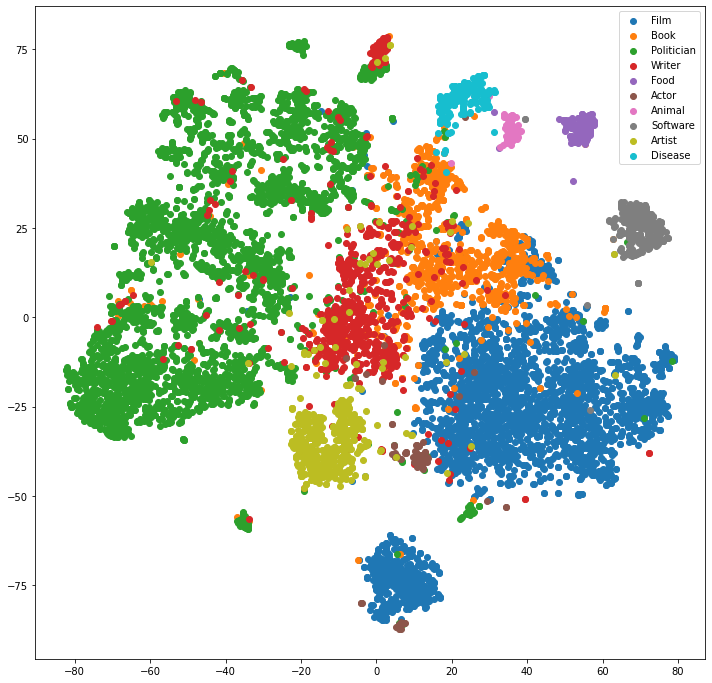

In [499]:
plotTSNE(doc2vec_mean,doc_label)

在此过程中，尝试了learning_rate和n_iter参数的影响。
+ leanring_rate: learning rate如果比较小的话，会导致聚类出来的效果像球一样，看不出聚类的效果。learning_rate比较大时，又会导致多数点看起来像是密集的云，几乎没有异常值。
+ n_iter: n_iter比较小的话，出来的效果看起来会像是还没来得及聚在一起，也就是降维没有收敛。但是太大的话，训练的时间又会大大增加。

## 使用部分单词的嵌入向量平均值的文档嵌入可视化

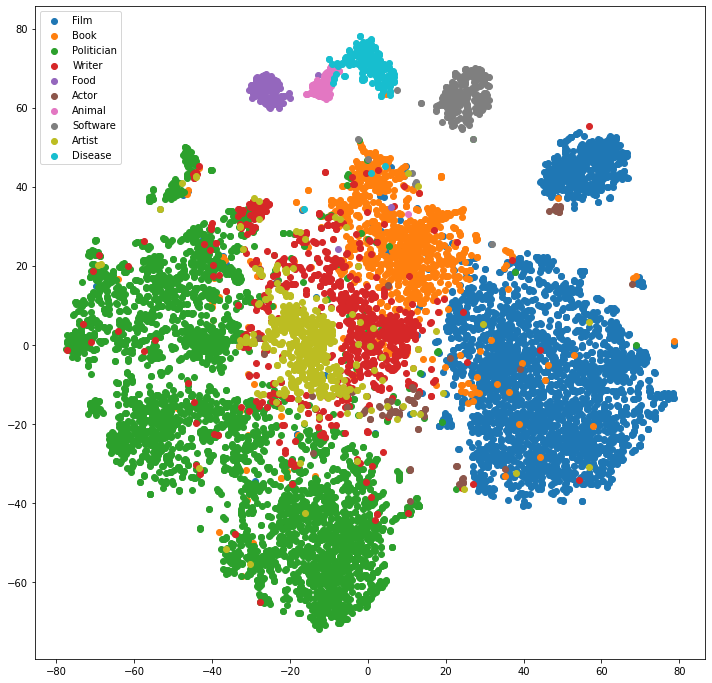

In [500]:
plotTSNE(doc2vec_part_mean,doc_label)

## 使用所有非停用单词嵌入向量平均值的文档嵌入可视化

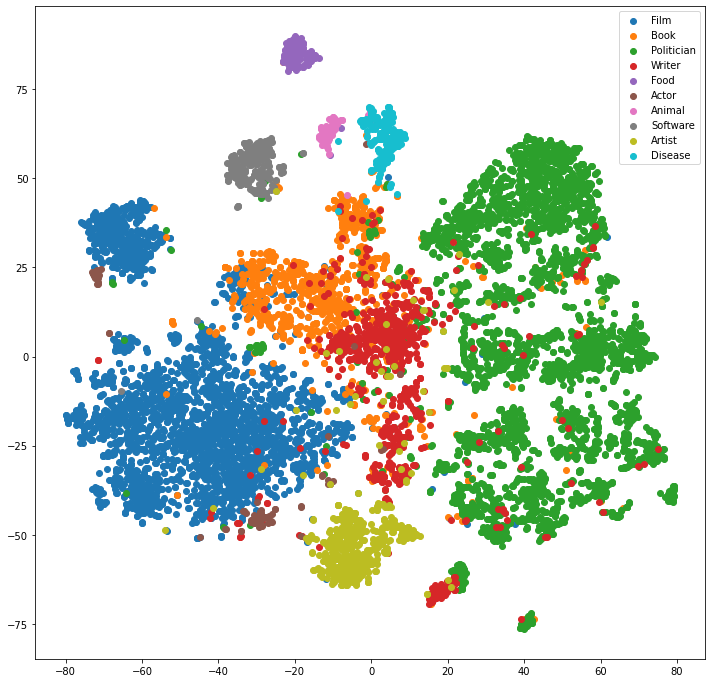

In [501]:
plotTSNE(doc2vec_stop_mean, doc_label)

## 使用部分非停用词加权嵌入向量和的文档嵌入可视化

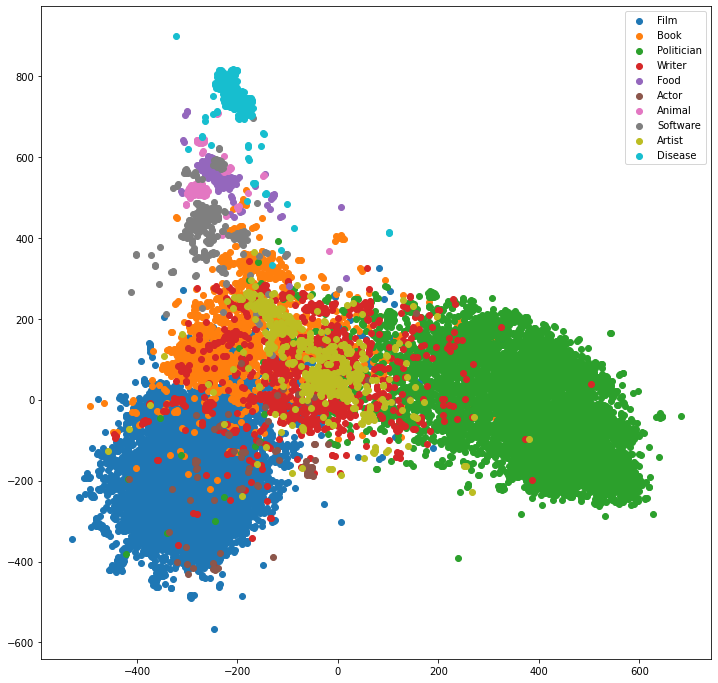

In [524]:
plotTSNE(doc2vec_weight_mean, doc_label)

可以从降维的效果看出来，聚类效果确实不如前面的几种嵌入方法好。

## 使用doc2vec算法嵌入的文档向量可视化

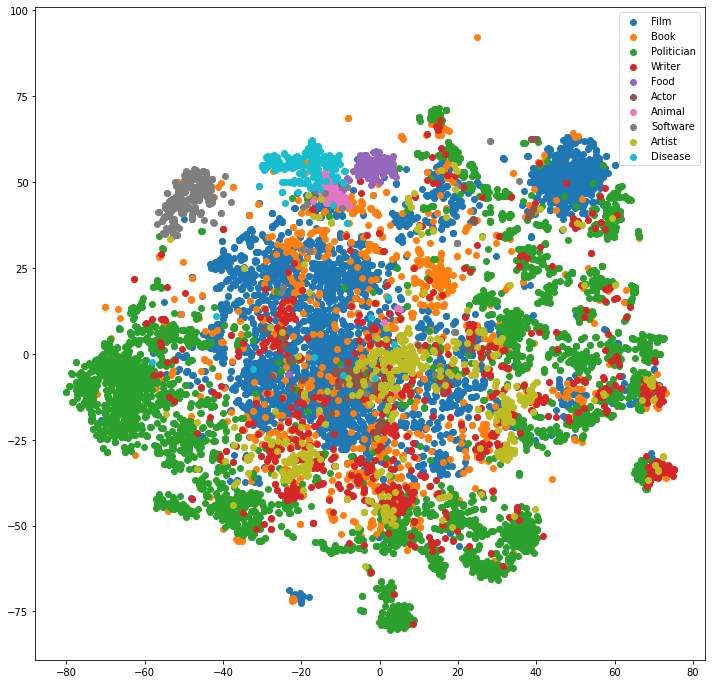

In [64]:
plotTSNE(doc2vec_doc.dv.vectors, doc_label)

可以看到doc2vec在该数据集上的聚类能力比起其他嵌入方法确实要差得多，同一类的数据大部分都没有聚在一起。
另外，使用其他聚类方法的可视化就不再展示了，因为使用的文档向量均来自于使用文档中的所有单词的嵌入向量平均值，之前已经展示过了。